## Importing Necessary Libraries
---

In [1]:
# Importing necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, Flatten, MaxPooling1D, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from tabulate import tabulate

## Load preprocessed data
---

In [2]:
X_train = pd.read_pickle("/Users/pranavkhot/Documents/Fetal Health Project/data/X_train.pkl")
X_test = pd.read_pickle("/Users/pranavkhot/Documents/Fetal Health Project/data/X_test.pkl")
y_train = pd.read_pickle("/Users/pranavkhot/Documents/Fetal Health Project/data/y_train.pkl")
y_test = pd.read_pickle("/Users/pranavkhot/Documents/Fetal Health Project/data/y_test.pkl")
X = pd.read_pickle("/Users/pranavkhot/Documents/Fetal Health Project/data/X.pkl")
y = pd.read_pickle("/Users/pranavkhot/Documents/Fetal Health Project/data/y.pkl")    

# One-hot encoding of labels
y_train_encoded = to_categorical(y_train)
y_test_encoded = to_categorical(y_test)

# Reshape data for CNN input
X_train = np.array(X_train).reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = np.array(X_test).reshape((X_test.shape[0], X_test.shape[1], 1))

## Building the CNN Model
---

In [7]:
def create_model(input_shape, num_classes):
    model = Sequential([
        Conv1D(32, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

model = create_model(X_train.shape[1:], y_train_encoded.shape[1])

## Training the CNN Model
---

In [8]:
history = model.fit(X_train, y_train_encoded, epochs=50, batch_size=32, validation_split=0.2, verbose=0)

# Make predictions
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

14/14 [==============================] - 0s 525us/step


## Model Evaluation
---

In [9]:
class_names = ['Normal', 'Suspect', 'Pathologic']

# Classification report
report = classification_report(y_test, y_pred_classes, target_names=class_names, output_dict=True)

# Convert the report to a DataFrame
df_report = pd.DataFrame(report).transpose()

# Print the classification report
print("\nClassification Report:")
print(tabulate(df_report, headers='keys', tablefmt='fancy_grid', floatfmt=".2f"))
print("\n")


Classification Report:
╒══════════════╤═════════════╤══════════╤════════════╤═══════════╕
│              │   precision │   recall │   f1-score │   support │
╞══════════════╪═════════════╪══════════╪════════════╪═══════════╡
│ Normal       │        0.94 │     0.95 │       0.95 │    332.00 │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Suspect      │        0.71 │     0.69 │       0.70 │     59.00 │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ Pathologic   │        0.88 │     0.80 │       0.84 │     35.00 │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ accuracy     │        0.91 │     0.91 │       0.91 │      0.91 │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ macro avg    │        0.84 │     0.82 │       0.83 │    426.00 │
├──────────────┼─────────────┼──────────┼────────────┼───────────┤
│ weighted avg │        0.91 │     0.91 │       0.91 │    426.00 │
╘══════════════╧═════════════╧════════

In [10]:
from sklearn.metrics import accuracy_score, f1_score

# Convert predictions to class labels if they are in probability form
y_pred_train = model.predict(X_train)
y_pred_train_classes = np.argmax(y_pred_train, axis=1)
y_train_true = np.argmax(y_train_encoded, axis=1)

# Calculate Train Accuracy
train_accuracy = accuracy_score(y_train_true, y_pred_train_classes) * 100

# Calculate Test Accuracy and F1-Score
test_accuracy = accuracy_score(y_test, y_pred_classes) * 100
f1 = f1_score(y_test, y_pred_classes, average='weighted') * 100

# Calculate Overall Accuracy
overall_accuracy = (train_accuracy + test_accuracy) / 2

# Create a dictionary to store different metrics
metrics_dict_cnn = {
    "Model": ["CNN"],
    "Train Accuracy": [f"{train_accuracy:.3f}%"],
    "Test Accuracy": [f"{test_accuracy:.3f}%"],
    "Overall Accuracy": [f"{overall_accuracy:.3f}%"],
    "F1-Score": [f"{f1:.3f}%"],
}

# Convert the dictionary to a DataFrame
metrics_df_cnn = pd.DataFrame(metrics_dict_cnn)

# Print the results
print("\nCNN Model Metrics:")
print(tabulate(metrics_df_cnn, headers='keys', tablefmt='fancy_grid', showindex=False))

# %%
# Save the DataFrame to a CSV file
metrics_df_cnn.to_csv("/Users/pranavkhot/Documents/Fetal Health Project/results/CNN/cnn_metrics.csv", index=False)

print("Metrics saved to 'cnn_metrics.csv'")


54/54 [==============================] - 0s 493us/step

CNN Model Metrics:
╒═════════╤══════════════════╤═════════════════╤════════════════════╤════════════╕
│ Model   │ Train Accuracy   │ Test Accuracy   │ Overall Accuracy   │ F1-Score   │
╞═════════╪══════════════════╪═════════════════╪════════════════════╪════════════╡
│ CNN     │ 92.647%          │ 90.610%         │ 91.629%            │ 90.541%    │
╘═════════╧══════════════════╧═════════════════╧════════════════════╧════════════╛
Metrics saved to 'cnn_metrics.csv'


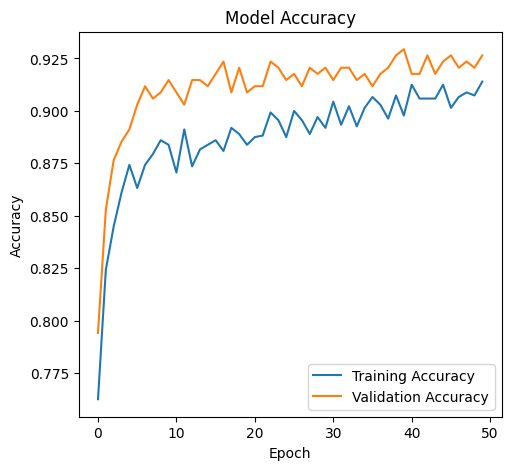

In [11]:
# Plotting the training history
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

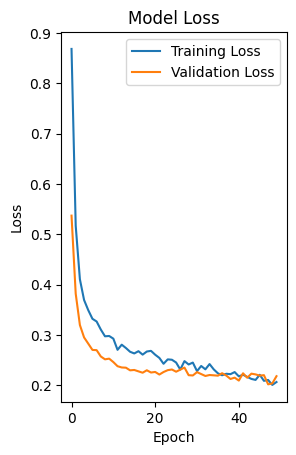

In [12]:
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()


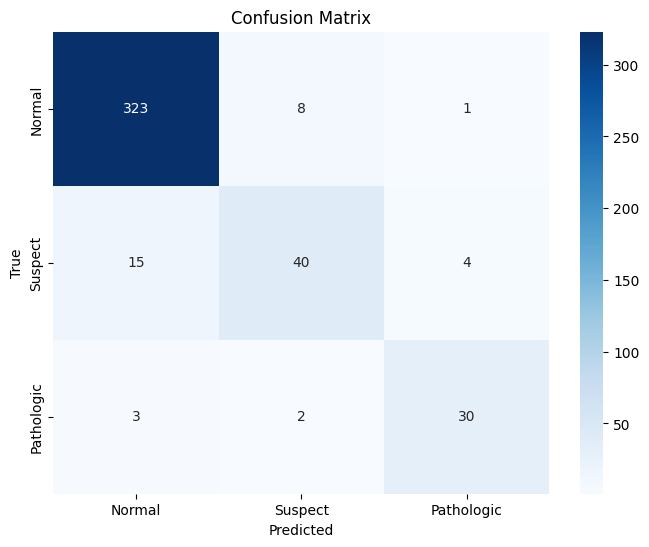

In [ ]:
# Plotting the confusion matrix
cm = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model.save('/Users/pranavkhot/Documents/Fetal Health Project/trained_models/CNN_model')

Model trained and saved to file.


In [1]:
import pandas as pd
import os

# Define the base path for your project's data
base_path = "/Users/pranavkhot/Documents/Fetal Health Project/data/"

# List of the original file names without extension
file_names = ['X_train', 'X_test', 'y_train', 'y_test', 'X', 'y']

# Create a directory for the CSV files if it doesn't already exist
csv_directory = os.path.join(base_path, "csv_files")
os.makedirs(csv_directory, exist_ok=True)

# Loop through each file, load the .pkl file, and save it as a .csv file
for file_name in file_names:
    # Load the .pkl file
    df = pd.read_pickle(os.path.join(base_path, f"{file_name}.pkl"))
    
    # Define the path to save the .csv file
    csv_path = os.path.join(csv_directory, f"{file_name}.csv")
    
    # Save the DataFrame as a .csv file
    df.to_csv(csv_path, index=False)
    
    print(f"Saved {file_name}.csv to {csv_directory}")


Saved X_train.csv to /Users/pranavkhot/Documents/Fetal Health Project/data/csv_files
Saved X_test.csv to /Users/pranavkhot/Documents/Fetal Health Project/data/csv_files
Saved y_train.csv to /Users/pranavkhot/Documents/Fetal Health Project/data/csv_files
Saved y_test.csv to /Users/pranavkhot/Documents/Fetal Health Project/data/csv_files
Saved X.csv to /Users/pranavkhot/Documents/Fetal Health Project/data/csv_files
Saved y.csv to /Users/pranavkhot/Documents/Fetal Health Project/data/csv_files
